In [87]:
from globus_automate_client import create_flows_client
import time
import json
import sys
import os

from datetime import datetime
from dateutil import parser
from itertools import chain

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

In [88]:
DATA_COMPUTE = {'xpcs': {'data': 2.415, 'fx': 122},
                'ssx': {'data': 3.453, 'fx': 317},
               'slac': {'data': 21.943, 'fx': 166},
               'ptycho': {'data': 0.048, 'fx': 2155},
               'hedm': {'data': 11.517, 'fx': 396}}

# Flow step counts

In [89]:
df = pd.read_csv('flow_data.csv')

In [90]:
dfcount = df.groupby(['experiment']).sum().reset_index()

In [91]:
dfcount

,experiment,Unnamed: 0,funcx_count,transfer_count,search_count,total_runs
0,hedm,5238656,785,380,171,188
1,ptycho,294557268,16415,39183,0,16296
2,slac,29847675,754,1497,0,744
3,ssx,701090759,65220,24322,2478,21346
4,xpcs,662740145,99083,53049,28424,19624


# Data and compute

In [92]:
df = pd.read_csv('flow_data.csv')

Truncate

In [93]:
df = df[(df['created'] > '2019-12-31') & (df['created'] < '2022-01-01')]
df = df[(df['experiment'] == 'ssx') | (df['experiment'] == 'xpcs') | (df['experiment'] == 'hedm') | (df['experiment'] == 'slac') | (df['experiment'] == 'ptycho')]

## 1. Flows over time

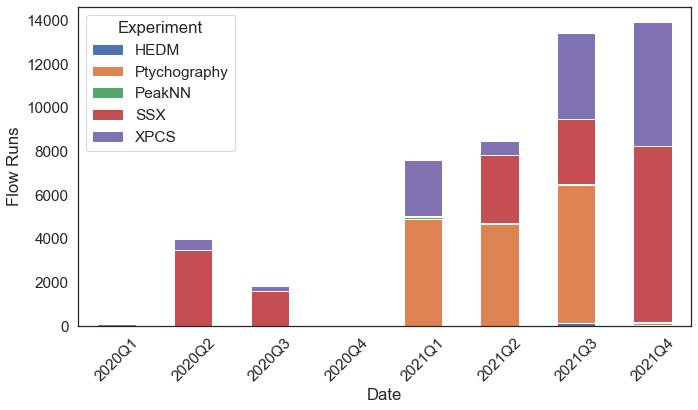

In [94]:
labels=['HEDM', 'Ptychography', 'PeakNN', 'SSX', 'XPCS']

df['count'] = 1
dfd = df.groupby(['quarter_col', 'experiment']).sum().reset_index()

dfq = dfd.pivot(index='quarter_col', columns='experiment', values='count')
dfq.plot.bar(stacked=True, figsize=(10, 6), ylabel='Flow Runs', xlabel='Date')
plt.legend(title='Experiment', loc='upper left', labels=labels)

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('agg_runs.png')

## 2. Data GB transferred

In [95]:
def add_data(row):
    return DATA_COMPUTE[row['experiment']]['data']

def add_compute(row):
    return DATA_COMPUTE[row['experiment']]['fx']
    
df['data'] = df.apply(lambda row: add_data(row), axis=1)
df['compute'] = df.apply(lambda row: add_compute(row), axis=1)

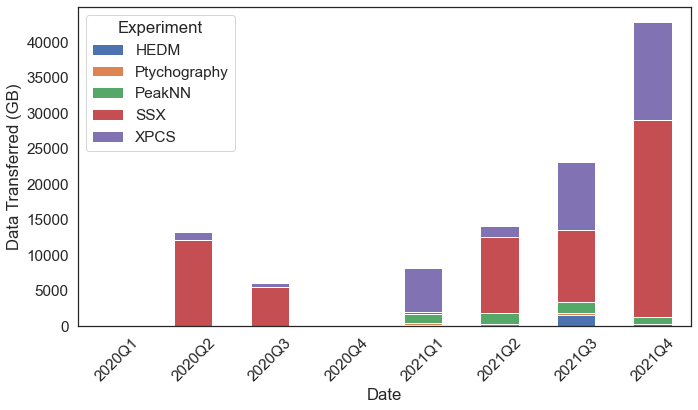

In [96]:
dfd = df.groupby(['quarter_col', 'experiment']).sum().reset_index()
# print(dfd)
dfq = dfd.pivot(index='quarter_col', columns='experiment', values='data')
dfq.plot.bar(stacked=True, figsize=(10, 6), ylabel='Data Transferred (GB)', xlabel='Date')
plt.legend(title='Experiment', loc='upper left', labels=labels)

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('agg_data.png')

## 3. Compute node seconds

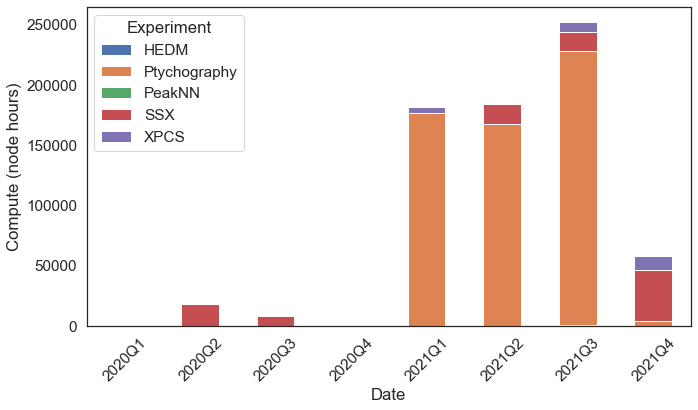

In [97]:
dfd = df.groupby(['quarter_col', 'experiment']).sum().reset_index()
dfd['compute'] = dfd['compute'] / 60
dfq = dfd.pivot(index='quarter_col', columns='experiment', values='compute')
dfq.plot.bar(stacked=True, figsize=(10, 6), ylabel='Compute (node hours)', xlabel='Date')
plt.legend(title='Experiment', loc='upper left', labels=labels)

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('agg_compute.png')

# Overhead

XPCS

In [16]:
df = pd.read_csv('xpcs_runs_2.csv')
# flow_id = 'bfe2b079-9a28-4584-bf4d-c8b755cdedfc' #xpcs
# flow_scope = f"https://auth.globus.org/scopes/{flow_id}/flow_{flow_id.replace('-','_')}_user"

In [17]:
df['start_time'] = [datetime.fromtimestamp(x) for x in df['start']]

In [18]:
rec = df.iloc(0)[0]
aid = rec['action_id']

In [19]:
# xpcs_funcx_ids = ['f0b96543-b720-4a59-8b76-e35478f3effa', 'b1988aaa-ef11-4851-ab83-9e636281efe1', '7ed915ca-2996-4081-b45e-302051128ae6', '75a4ee97-7ffa-460f-bcdd-28af61a2e57f', 'fc7c384d-d457-4a7d-b307-26d3ae1f0740', 'ccaaee37-2f35-45a6-b7da-e56034c9e8cf']

In [20]:
fx_map = {'PrePublishGatherMetadata': '8ce4e858-8da2-4bb7-a188-323ddff77e80',
 'AcquireNodes': 'f82ce53f-467f-4c49-9ac3-d278341ab4cf',
 'XpcsBoostCorr': '62b02c2d-ea5a-4ba4-aca7-c9e175a8b47e',
 'MakeCorrPlots': 'd67069b0-faca-42ac-a34d-777fed84d3a6',
 'GatherXpcsMetadata': '4db5ddba-be38-417c-b556-2e306185a994',
 'PublishGatherMetadata': '1347dc22-51ff-41bf-9cf5-8b20eb8e6f97'}

map_fx = {}
fx_list = []
for k,v in fx_map.items():
    fx_list.append(v)
    map_fx[v] = k

In [21]:
flow_runtime = rec['flow_runtime']

Sum runtime fields per action type

In [23]:
plot_exp = []
action_runtimes = 0
transfer_action_time = 0
fx_action_time = 0
search_action_time = 0
for x in rec.keys():
    if '_runtime' in x:
        if x != "flow_runtime":
            action_runtimes += rec[x]
            if "ransfer" in x:
                transfer_action_time += rec[x]
                plot_exp.append({'type': 'transfer', 'name': x.replace("_runtime", ""), 'runtime': rec[x]})
            elif "Gather" in x or "Acquire" in x or "Corr" in x:
                fx_action_time += rec[x]
                plot_exp.append({'type': 'funcx', 'name': x.replace("_runtime", ""), 'runtime': rec[x]})
            elif "Ingest" in x:
                search_action_time += rec[x]
                plot_exp.append({'type': 'search', 'name': x.replace("_runtime", ""), 'runtime': rec[x]})
print(action_runtimes)
print(transfer_action_time)
print(fx_action_time)
print(search_action_time)

240.0250005722046
29.157000303268433
200.37900018692017
10.489000082015991


In [24]:
with open('xpcs_flow_log.json', 'r') as fp:
    flow_logs = json.load(fp)

Add in overhead by computing how long the actions stated they took to perform the tasks

In [27]:
flow_log = flow_logs['entries'][-1]

total_funcx_time = 0
total_transfer_time = 0
transfer_usage = {}
total_bytes_transferred = 0
total_ingest_time = 0
for k, v in flow_log['details']['output'].items():
    if 'details' in v:
        if 'bytes_transferred' in v['details']:
            r_t = parser.parse(v['details']['request_time'])
            c_t =  parser.parse(v['details']['completion_time'])
            run_t = (c_t - r_t).total_seconds()
            total_transfer_time += run_t
            transfer_usage[f"{k}_bytes_transferred"] = v['details']['bytes_transferred']
            total_bytes_transferred += v['details']['bytes_transferred']
            for ep in plot_exp:
                if ep['name'] == k:
                    ep['real_time'] = run_t
                    ep['overhead'] = ep['runtime'] - run_t
        if 'index_id' in v['details']:
            r_t = parser.parse(v['details']['creation_date'])
            c_t =  parser.parse(v['details']['completion_date'])
            run_t = (c_t - r_t).total_seconds()
            total_ingest_time += run_t
            for ep in plot_exp:
                if ep['name'] == k:
                    ep['real_time'] = run_t
                    ep['overhead'] = ep['runtime'] - run_t
transfer_usage['total_bytes_transferred'] = total_bytes_transferred

Resolve the funcx AP ids to funcx ids... magic

In [29]:
df_fx = pd.read_csv('logs-insights-xpcs.csv')

def jify(x):
    tmp = x.replace('\\r\\n', '').replace('\n', '')
    return json.loads(tmp)

df_fx['data'] = df_fx.apply(lambda row : jify(row['@message']), axis = 1)

df2 = pd.DataFrame()
for x in df_fx['data']:
    df2 = df2.append(x['log_processed'], ignore_index=True)

df2['asctime'] =  pd.to_datetime(df2['asctime'])

task_list = df2['task_id'].unique()

In [31]:
tasks = pd.DataFrame()
for t in task_list:
    df3 = df2[df2['task_id'] == t]
    if len(df3) == 4:
        new_rec = {'task_id': t,
                   'received': df3[df3['message']=='received'].iloc[0]['asctime'],
                   'dispatched_to_endpoint': df3[df3['message']=='dispatched_to_endpoint'].iloc[0]['asctime'],
                   'result_enqueued': df3[df3['message']=='result_enqueued'].iloc[0]['asctime'],
                   'user_fetched': df3[df3['message']=='user_fetched'].iloc[0]['asctime'],
                   'task_group_id': df3.iloc[0]['task_group_id'],
                   'user_id': df3.iloc[0]['user_id'],
                   'function_id': df3.iloc[0]['function_id'],
                   'endpoint_id': df3.iloc[0]['endpoint_id'],
                   'container_id': df3.iloc[0]['container_id'],
                  }
        if 'execution_start' in df3[df3['message']=='result_enqueued'].iloc[0]['times']:
            new_rec.update({'execution_start': df3[df3['message']=='result_enqueued'].iloc[0]['times']['execution_start'],
                   'execution_end': df3[df3['message']=='result_enqueued'].iloc[0]['times']['execution_end'],
                   'execution_time': df3[df3['message']=='result_enqueued'].iloc[0]['times']['execution_time']})
#         else:
#             print("no exec data for ep:", df3.iloc[0]['endpoint_id'],)
        new_rec.update({'total_funcx_time': (new_rec['user_fetched'] - new_rec['received']).total_seconds()})
        new_rec.update({'total_endpoint_time': ((new_rec['result_enqueued'] - new_rec['dispatched_to_endpoint']).total_seconds())})

        tasks = tasks.append(new_rec, ignore_index=True)

In [32]:
for ep in plot_exp:
    if ep['type'] == 'funcx':
        ep['real_time'] = tasks[tasks['function_id'] == fx_map[ep['name']]]['total_funcx_time'].values[0]
        ep['overhead'] = ep['runtime'] - ep['real_time']

In [33]:
sum_task_time = total_ingest_time+total_transfer_time+sum(tasks['total_funcx_time'])
overhead = flow_runtime - sum_task_time
print(f"XPCS Flow - {aid}\n")
print(f"Flow:\n\tflow runtime: {flow_runtime}\n\tsum_action_runtimes: {action_runtimes}\n\tsum_task_time: {sum_task_time}\n\toverhead: {overhead}")
print(f"Transfers\n\ttransfer_action_time: {transfer_action_time}\n\ttotal_transfer_time: {total_transfer_time}")
print(f"funcX\n\tfuncx_action_time: {fx_action_time}\n\tfuncx_task_time: {sum(tasks['total_funcx_time'])}")
print(f"Search\n\tsearch_action_time: {search_action_time}\n\ttotal_search_time: {total_ingest_time}")

XPCS Flow - 674f307e-7e0b-4db6-8c74-702ce2156f94

Flow:
	flow runtime: 240.78094100952148
	sum_action_runtimes: 240.0250005722046
	sum_task_time: 191.921
	overhead: 48.85994100952149
Transfers
	transfer_action_time: 29.157000303268433
	total_transfer_time: 12.0
funcX
	funcx_action_time: 200.37900018692017
	funcx_task_time: 177.921
Search
	search_action_time: 10.489000082015991
	total_search_time: 2.0


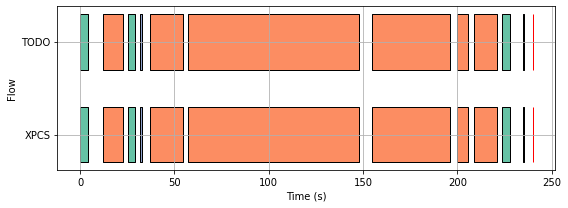

In [34]:
def plot_overhead(exps):
    fig, gnt = plt.subplots(figsize=(8, 3))
    gnt.grid(True)

    colors = sns.color_palette('Set2')

    def get_col(tasktype):
        if tasktype == 'transfer':
            return colors[0]
        if tasktype == 'funcx':
            return colors[1]
        if tasktype == 'search':
            return colors[2]

    i = 0
    for exp in exps:
        total = 0
        for task in exp:
            gnt.broken_barh([(total, task['real_time'])], ((i+1)*10, 6), facecolor=get_col(task['type']), edgecolor='black')
            total += task['runtime']
        gnt.broken_barh([(total, 0)], ((i+ 1)*10, 6), facecolor=get_col(4), edgecolor='red')
        i += 1
        
    
#     plt.xticks(rotation=45)
    # ylabel='Compute (node hours)', xlabel='Date'
    plt.xlabel("Time (s)")
    plt.ylabel("Flow")
    
    plt.yticks([13, 23], ("XPCS",'TODO'))
    plt.tight_layout()
    plt.savefig('overhead_breakdown.png')
    
plot_overhead([plot_exp, plot_exp])

# Runtime histograms

In [148]:
df = pd.read_csv('xpcs_runs_2.csv')

df['Date'] = pd.to_datetime(df['start'], unit='s')

df['date_col'] = df['Date'].dt.to_period('M') 
df['quarter_col'] = df['Date'].dt.to_period('Q')
df['day_col'] = df['Date'].dt.to_period('D')

df['experiment'] = 'xpcs'

In [149]:
cols = []
for exp in plot_exp:
    cols.append(exp['name'] + "_runtime")
df2 = df[cols[0]]

TransferFromClutchToTheta_runtime
PrePublishGatherMetadata_runtime
PrePublishTransfer_runtime
PrePublishIngest_runtime
AcquireNodes_runtime
XpcsBoostCorr_runtime
MakeCorrPlots_runtime
GatherXpcsMetadata_runtime
PublishGatherMetadata_runtime
PublishTransfer_runtime
PublishIngest_runtime


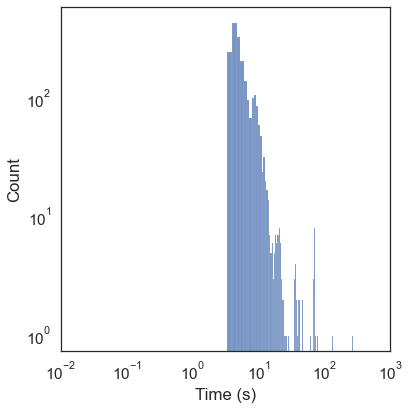

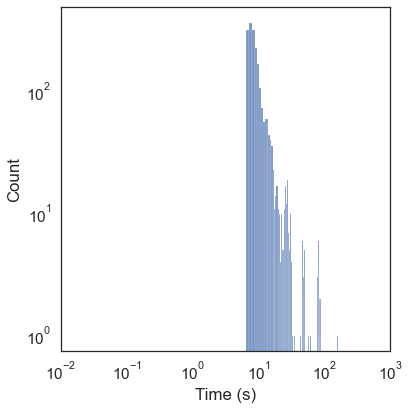

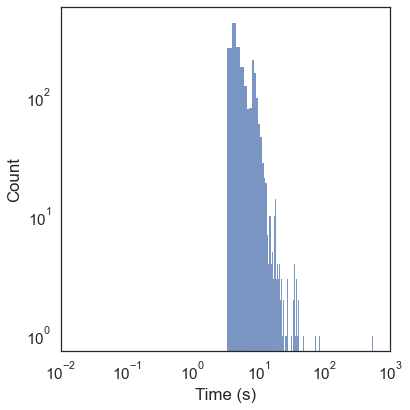

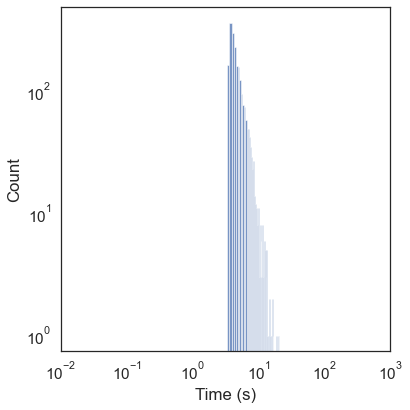

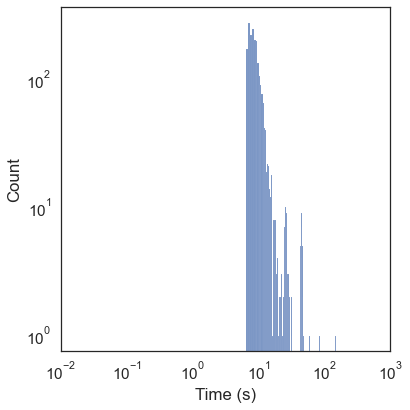

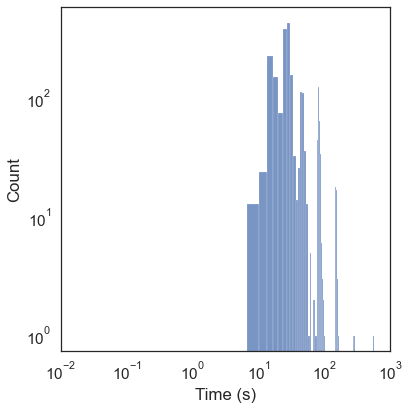

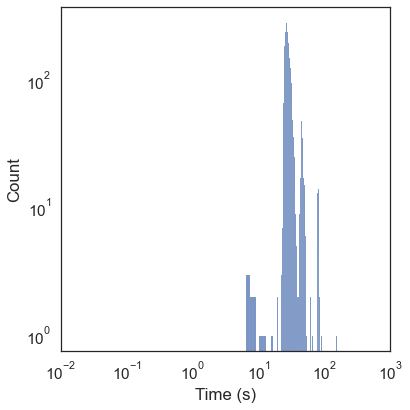

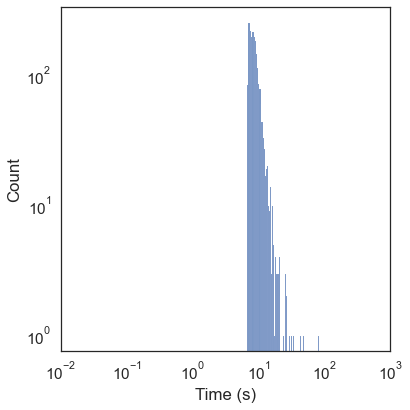

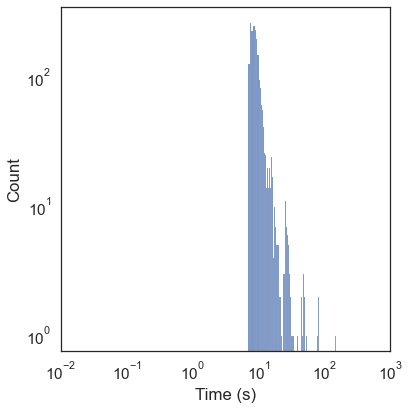

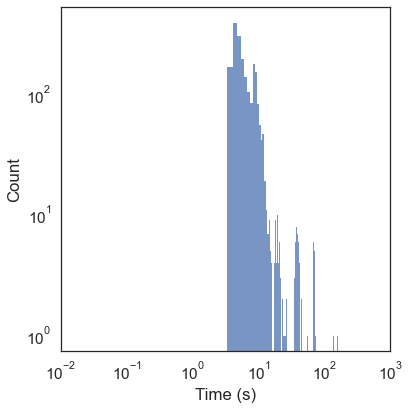

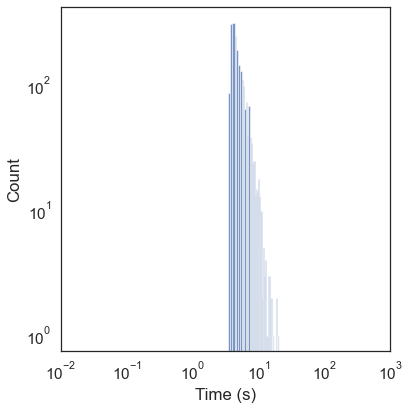

In [153]:
for coln in cols:
    df2 = df[coln]
    print(coln)
    sns.set(font_scale=1.4, style='white')
    plt.figure(figsize=(6,6))
    ax = sns.histplot(data=df2)

    ax.set_ylabel("Count")
    ax.set_xlabel("Time (s)")
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.set_xlim([0.01,1000])
    plt.tight_layout()
    plt.savefig(f'xpcs_{coln.lower()}.png')

#     plt.show()
    
#     break

TransferFromClutchToTheta_runtime
PrePublishGatherMetadata_runtime
PrePublishTransfer_runtime
PrePublishIngest_runtime
AcquireNodes_runtime
XpcsBoostCorr_runtime
MakeCorrPlots_runtime
GatherXpcsMetadata_runtime
PublishGatherMetadata_runtime
PublishTransfer_runtime
PublishIngest_runtime


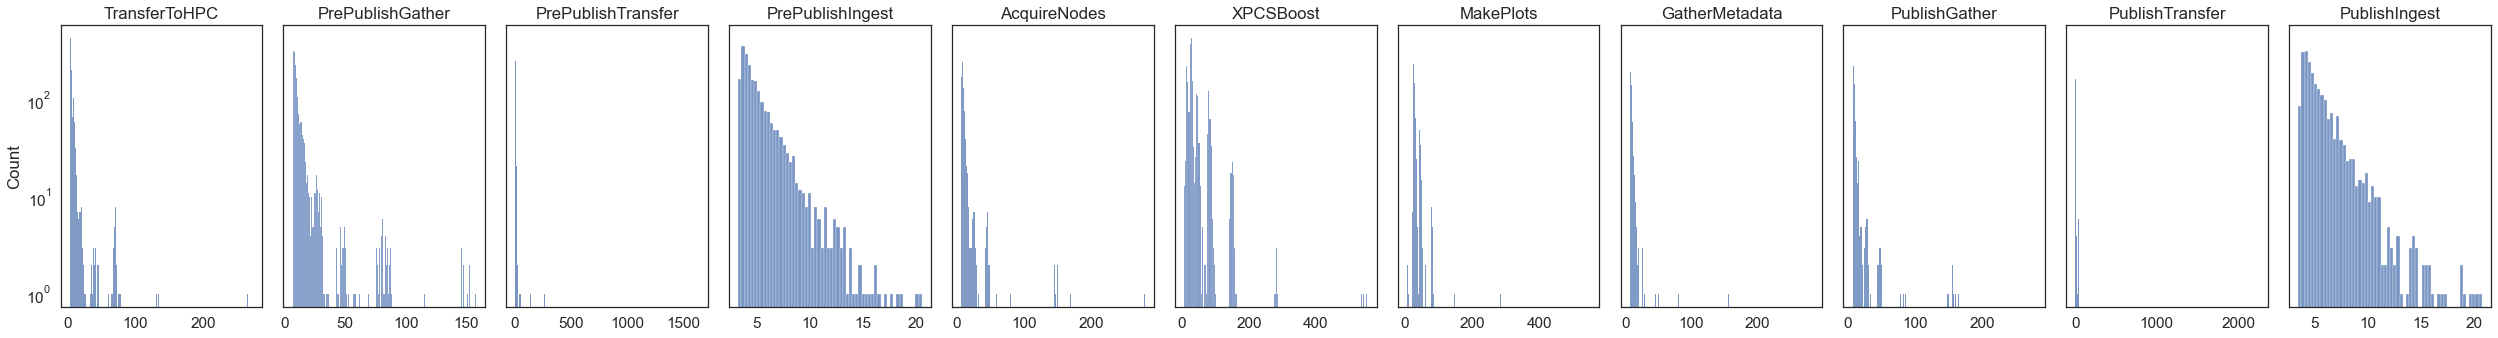

In [151]:
hist_labels = {'TransferFromClutchToTheta': 'TransferToHPC',
         'PrePublishGatherMetadata': 'PrePublishGather',
         'PrePublishTransfer': 'PrePublishTransfer',
         'PrePublishIngest': 'PrePublishIngest',
         'AcquireNodes': 'AcquireNodes',
         'XpcsBoostCorr': 'XPCSBoost',
         'MakeCorrPlots': 'MakePlots',
         'GatherXpcsMetadata': 'GatherMetadata',
         'PublishGatherMetadata': 'PublishGather',
         'PublishTransfer': 'PublishTransfer',
         'PublishIngest': 'PublishIngest'}

cols = []
for exp in plot_exp:
    cols.append(exp['name'] + "_runtime")
df2 = df[cols[0]]

sns.set(font_scale=1.4, style='white')
fig, axs = plt.subplots(ncols=11, sharey=True, sharex=False, figsize=(35,5), )
i = 0
for coln in cols:
    df2 = df[coln]
    print(coln)
    ax = sns.histplot(data=df2, ax=axs[i])
    ax.set_title(hist_labels[coln.replace("_runtime","")])
    ax.set_xlabel(None)
    i+=1
    ax.set_yscale("log")
    plt.tight_layout()
plt.savefig(f'xpcs_runtime_hists.png')

plt.show()

# Overhead historgrams

In [139]:
tasks = pd.read_csv('tasks_overheads.csv')
df = pd.read_csv('xpcs_runs_2.csv')
df['PublishGatherMetadata_action_time'] = np.nan
df['AcquireNodes_action_time'] = np.nan
df['XpcsBoostCorr_action_time'] = np.nan
df['MakeCorrPlots_action_time'] = np.nan
df['GatherXpcsMetadata_action_time'] = np.nan

In [140]:
for index, row in df.iterrows():
    for y in json.loads(row['funcx_task_ids'].replace("\'", "\"")):
        try:
            fxtask = tasks[tasks['aid'] == y]
            fxt = fxtask['total_funcx_time'].values[0]
            df.at[index,map_fx[fxtask['function_id'].values[0]]+"_action_time"] = fxt
        except Exception as e:
            pass

Now we have action_time and runtime on each action in the df dataframe. compute overhead, then plot.

In [141]:
filter_col = [col for col in df if col.endswith('_runtime')]

In [142]:
for c in filter_col:
    if c == "flow_runtime":
        continue
    cn = c.split("_")[0]
    df[cn+"_overhead"] = df[cn+"_runtime"] - df[cn+"_action_time"]

In [143]:
df['PrePublishIngest_overhead']

0       4.069
1       8.590
2       4.393
3       3.765
4       3.209
        ...  
2192    7.048
2193    5.231
2194    3.808
2195    3.817
2196    4.085
Name: PrePublishIngest_overhead, Length: 2197, dtype: float64

TransferFromClutchToTheta_overhead


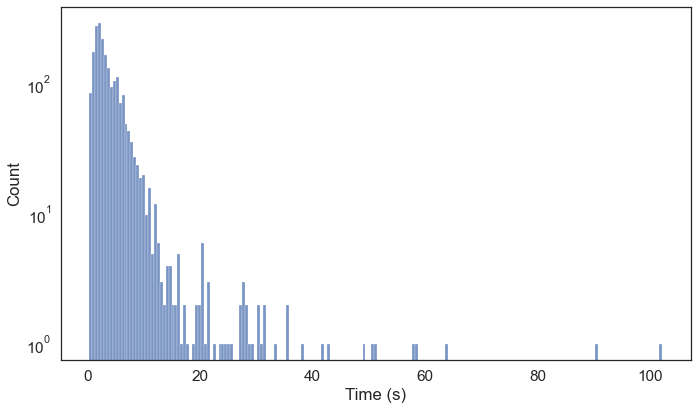

PrePublishGatherMetadata_overhead


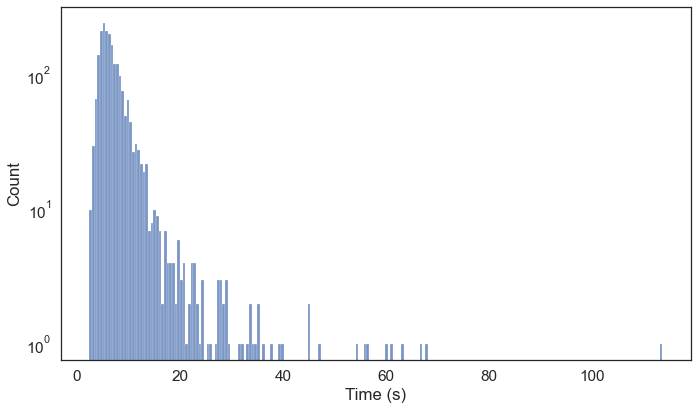

PrePublishTransfer_overhead


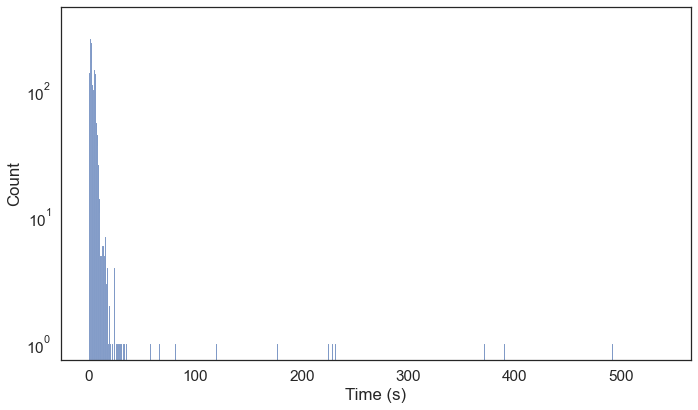

PrePublishIngest_overhead


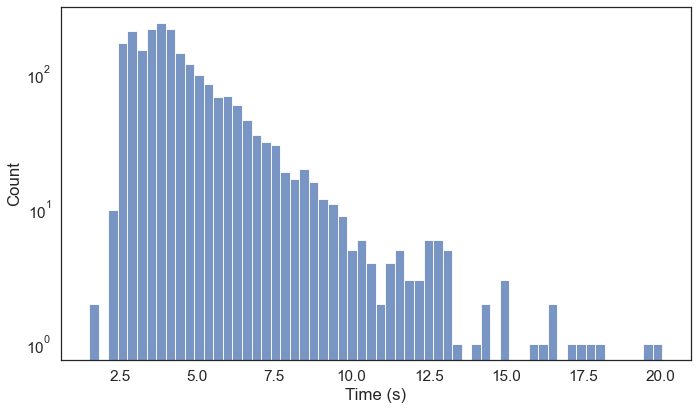

AcquireNodes_overhead


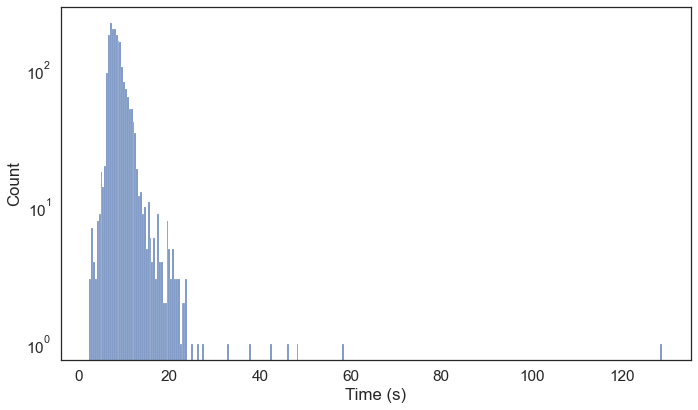

XpcsBoostCorr_overhead


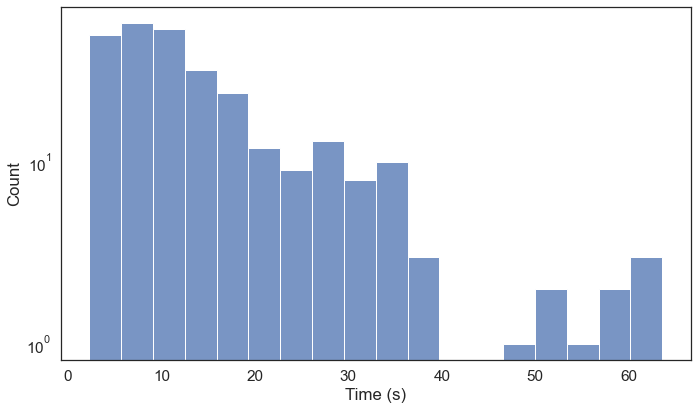

MakeCorrPlots_overhead


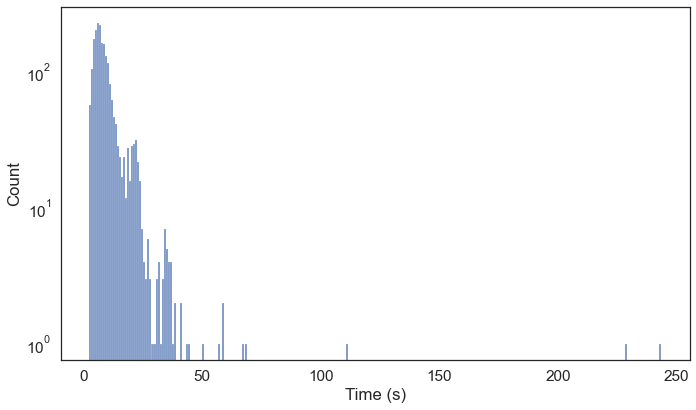

GatherXpcsMetadata_overhead


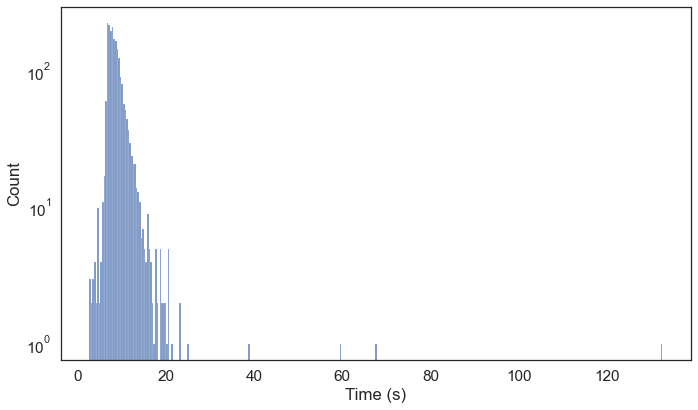

PublishGatherMetadata_overhead


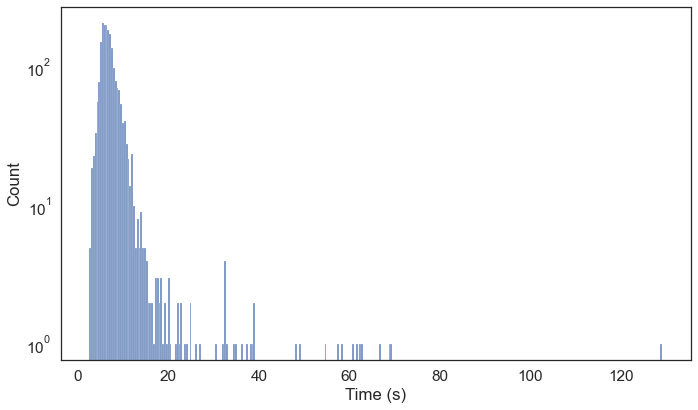

PublishTransfer_overhead


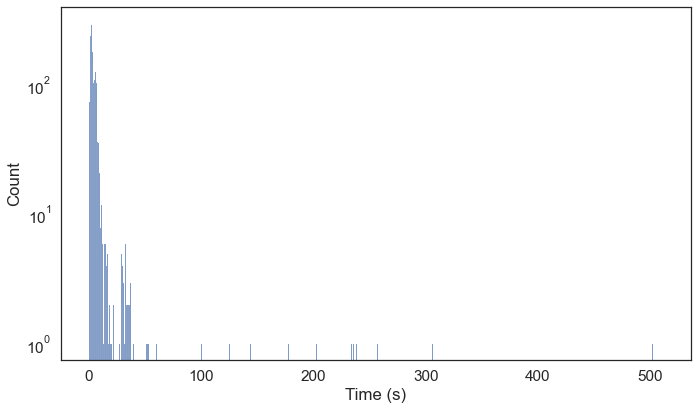

PublishIngest_overhead


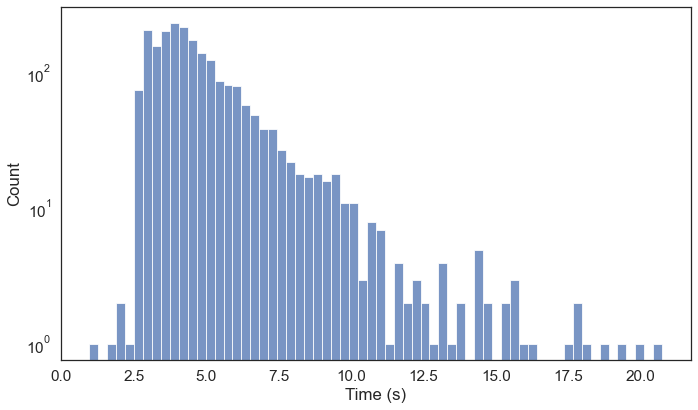

In [144]:
filter_col = [col for col in df if col.endswith('_overhead')]

for coln in filter_col:
    df2 = df[coln]
    
    print(coln)
    sns.set(font_scale=1.4, style='white')
    plt.figure(figsize=(10,6))
    ax = sns.histplot(data=df2)

    ax.set_ylabel("Count")
    ax.set_xlabel("Time (s)")
    ax.set_yscale("log")
    plt.tight_layout()
    plt.savefig(f'xpcs_{coln.lower()}.png')

#     plt.show()

TransferFromClutchToTheta_overhead
PrePublishGatherMetadata_overhead
PrePublishTransfer_overhead
PrePublishIngest_overhead
AcquireNodes_overhead
XpcsBoostCorr_overhead
MakeCorrPlots_overhead
GatherXpcsMetadata_overhead
PublishGatherMetadata_overhead
PublishTransfer_overhead
PublishIngest_overhead


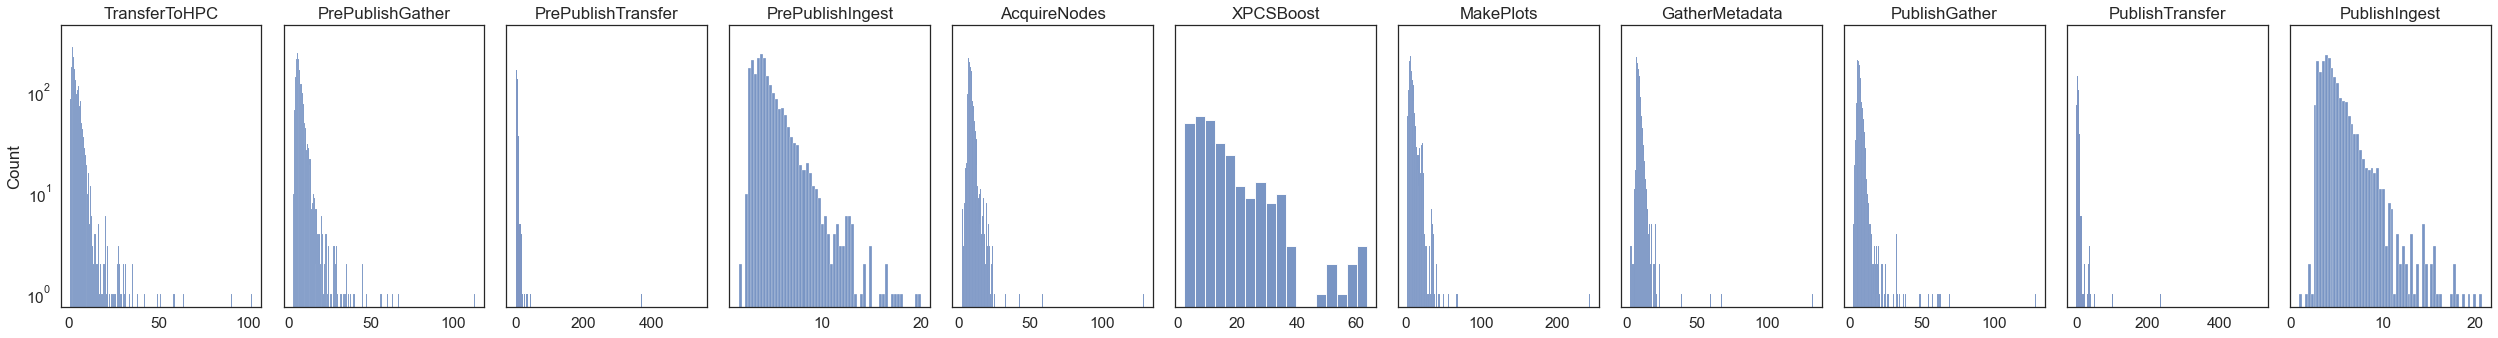

In [147]:
filter_col = [col for col in df if col.endswith('_overhead')]

sns.set(font_scale=1.4, style='white')
fig, axs = plt.subplots(ncols=11, sharey=True, sharex=False, figsize=(35,5), )
i = 0
for coln in filter_col:
    df2 = df[coln]
    print(coln)
    ax = sns.histplot(data=df2, ax=axs[i])
    ax.set_title(hist_labels[coln.replace("_overhead", "")])
    ax.set_xlabel(None)
    i+=1
    ax.set_yscale("log")
    plt.tight_layout()
plt.savefig(f'xpcs_overhead_hists.png')

plt.show()

# Concurrent flows

In [64]:
df = pd.read_csv('xpcs_runs_2.csv')

In [65]:
df2 = df
active_events= []
for i in df2.index:
    active_events.append(len(df2[(df2["start"]<=df2.loc[i,"start"]) & 
                                (df2["end"]> df2.loc[i,"start"])]))
df2['activecalls'] = pd.Series(active_events)

<AxesSubplot:xlabel='start', ylabel='activecalls'>

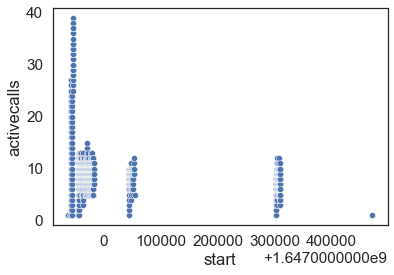

In [66]:
sns.scatterplot(data=df2, x='start', y='activecalls')

In [67]:
df2 = df

df2['Date'] = pd.to_datetime(df2['start'], unit='s')
df2['date_hour'] = df2['Date'].dt.to_period('h') 
df2 = df2[(df2['Date'] > '2022-03-11') & (df2['Date'] < '2022-03-12')]

In [68]:
active_events = []
for i in df2.index:
    active_events.append(len(df2[(df2["start"]<=df2.loc[i,"start"]) & 
                                (df2["end"]> df2.loc[i,"start"])]))
df2['activecalls'] = pd.Series(active_events)

<ipython-input-68-950de3ec59f4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['activecalls'] = pd.Series(active_events)


<AxesSubplot:xlabel='Date', ylabel='activecalls'>

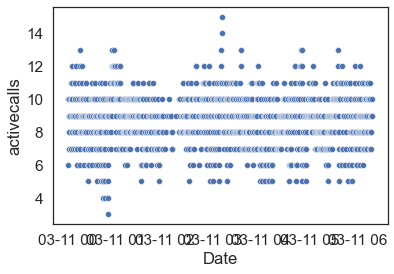

In [69]:
sns.scatterplot(data=df2, x='Date', y='activecalls')

In [70]:
dfx = df

In [71]:
dfx['start'] = pd.to_datetime(dfx['start'], unit='s')
dfx['end'] = pd.to_datetime(dfx['end'], unit='s')

In [72]:
starts = (x - pd.Timedelta(seconds=x.second) for x in dfx['start'])
ends = (x - pd.Timedelta(seconds=x.second) for x in dfx['end'])
ranges = (pd.date_range(x,y,freq='1D') for x,y in zip(starts,ends))
ranges = pd.Series(chain.from_iterable(ranges))
output = ranges.value_counts(sort=False).sort_index()

In [73]:
df2 = df[(df['Date'] > '2022-03-10') & (df['Date'] < '2022-03-12')]
min_time = df2['start'].min()
max_time = df2['end'].max()
ts_index = pd.date_range(min_time, max_time, freq = 's')

In [74]:
concurrency_array = dfx.apply(lambda e: ((ts_index >= e['start']) & (ts_index <= e['end'])).astype(int), axis='columns').sum()
concurrency = pd.Series(concurrency_array, index = ts_index)

In [75]:
concurrency.describe()

count    45513.000000
mean         5.558873
std          5.286086
min          0.000000
25%          0.000000
50%          7.000000
75%          9.000000
max         39.000000
dtype: float64

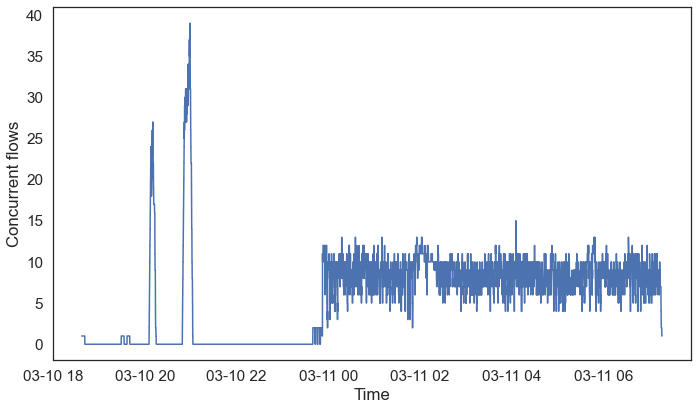

In [76]:
sns.set(font_scale=1.4, style='white')
plt.figure(figsize=(10,6))
p = sns.lineplot(data=concurrency)

p.set_ylabel("Concurrent flows")
p.set_xlabel("Time")

plt.tight_layout()
plt.savefig('concurrent_flows.png')

In [79]:
# Can resample to whatever binning period
concurrency2 = concurrency.resample('1H').max()

<AxesSubplot:>

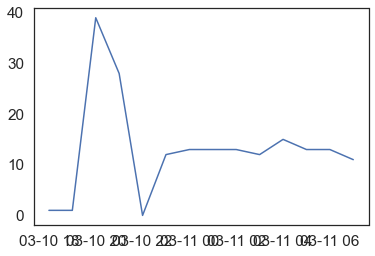

In [80]:
sns.lineplot(data=concurrency2)

# Runtime distributions

In [171]:
# Start with XPCS data as its easiest

df = pd.read_csv('xpcs_runs_2.csv')
df['experiment'] = 'XPCS'
df_xpcs = df[['flow_runtime', 'experiment']]


# SSX
df_stills = pd.read_csv('stills_runs.csv')
df_stills['experiment'] = 'SSX-Stills'
df_prime = pd.read_csv('prime_runs.csv')
df_prime['experiment'] = 'SSX-PRIME'
df_transfer = pd.read_csv('ssx_transfer_runs.csv')
df_transfer['experiment'] = 'SSX-Transfer'

# SLAC
df_slac = pd.read_csv('slac_runs.csv')
df_slac['experiment'] = 'PeakNN'

# Ptycho
df_ptycho = pd.read_csv('ptycho_runs.csv')
df_ptycho['experiment'] = 'Ptychography'

df_all = df[['flow_runtime', 'experiment']]
df_all = df_all.append(df_stills[['flow_runtime', 'experiment']], ignore_index=True)
df_all = df_all.append(df_prime[['flow_runtime', 'experiment']], ignore_index=True)
df_all = df_all.append(df_transfer[['flow_runtime', 'experiment']], ignore_index=True)
df_all = df_all.append(df_slac[['flow_runtime', 'experiment']], ignore_index=True)
df_all = df_all.append(df_ptycho[['flow_runtime', 'experiment']], ignore_index=True)

In [172]:
df_ptycho['flow_runtime'].describe()

count      74.000000
mean     2177.131975
std      1420.733539
min        31.397206
25%       553.929436
50%      2879.614328
75%      3488.519938
max      3527.506117
Name: flow_runtime, dtype: float64

/Users/ryan/.miniforge3/envs/gladier/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/ryan/.miniforge3/envs/gladier/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/Users/ryan/.miniforge3/envs/gladier/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `di

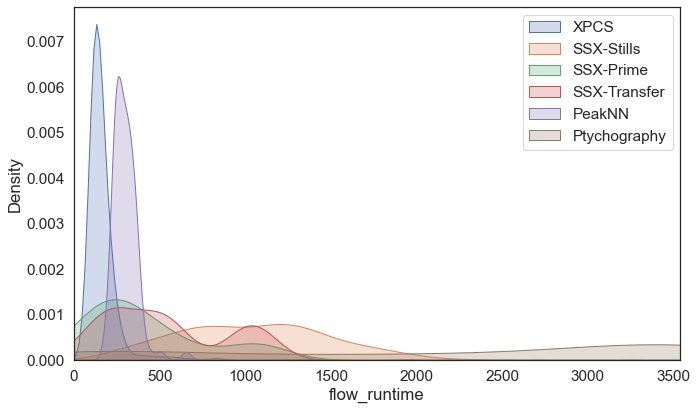

In [173]:
sns.set(font_scale=1.4, style='white')
plt.figure(figsize=(10,6))

ax = sns.distplot(df_xpcs['flow_runtime'], hist=False, label='XPCS', kde_kws={"shade": True}).set(xlim=(0))
ax = sns.distplot(df_stills['flow_runtime'], hist=False, label='SSX-Stills', kde_kws={"shade": True}).set(xlim=(0))
ax = sns.distplot(df_prime['flow_runtime'], hist=False, label='SSX-Prime', kde_kws={"shade": True}).set(xlim=(0))
ax = sns.distplot(df_transfer['flow_runtime'], hist=False, label='SSX-Transfer', kde_kws={"shade": True}).set(xlim=(0))
ax = sns.distplot(df_slac['flow_runtime'], hist=False, label='PeakNN', kde_kws={"shade": True}).set(xlim=(0))
ax = sns.distplot(df_ptycho['flow_runtime'], hist=False, label='Ptychography', kde_kws={"shade": True}).set(xlim=(0))

plt.legend()

plt.tight_layout()
plt.savefig('runtime_distribution.png')

<Figure size 720x432 with 0 Axes>

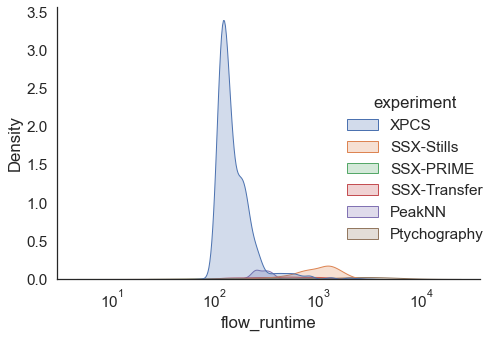

In [193]:
sns.set(font_scale=1.4, style='white')
plt.figure(figsize=(10,6))

ax = sns.displot(df_all, x="flow_runtime",kind='kde', fill=True, hue='experiment', log_scale=True)

plt.tight_layout()
plt.savefig('runtime_displot.png')

In [175]:
# ax = sns.kdeplot(data=df_all, x='flow_runtime', hue='experiment')

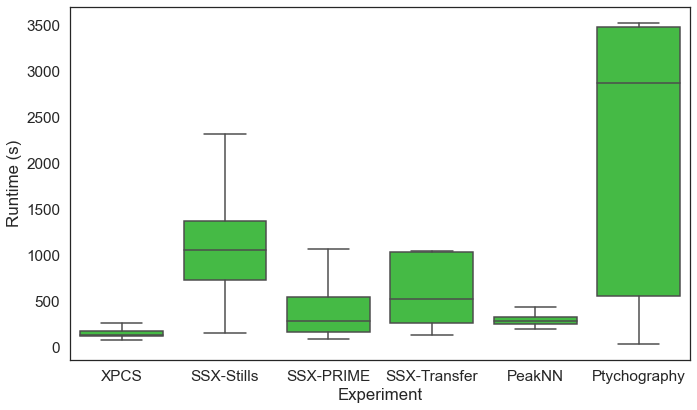

In [192]:
sns.set(font_scale=1.4, style='white')
plt.figure(figsize=(10,6))

ax = sns.boxplot(x="experiment", y="flow_runtime", color="limegreen", data=df_all, showfliers=False)
ax.set_ylabel("Runtime (s)")
ax.set_xlabel("Experiment")

plt.tight_layout()
plt.savefig('runtime_boxplot.png')